# Using Explainers and Metrics in GraphXAI
Here, we'll walk through a quick example where we 1) generate a synthetic dataset that is ready for XAI evaluation, 2) train a GNN model, 3) explain the GNN model with two types of explainers, and 4) evaluate the output explanations from each explainer.

In [ ]:
import torch
import matplotlib.pyplot as plt
from graphxai.datasets import ShapeGraph

First we load the dataset and run a quick plot of the dataset.

100%|██████████| 53/53 [00:00<00:00, 281.69it/s]


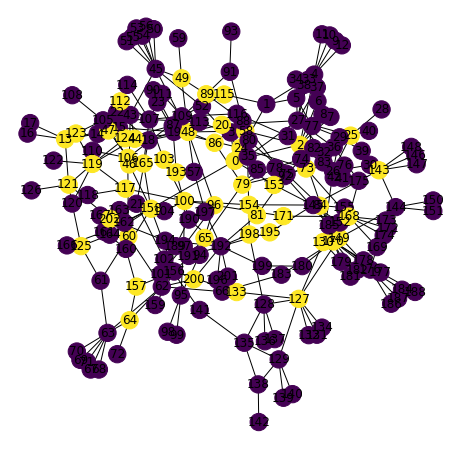

In [11]:
# Get dataset:
dataset = ShapeGraph(
    model_layers = 2,
    num_subgraphs = 15,
    subgraph_size = 13,
    prob_connection = 0.3,
    add_sensitive_feature = False
)

plt.figure(figsize = (8, 8))
dataset.visualize(show = True)

In [12]:
# Train a model from scratch on the data:
from torch_geometric.nn import GINConv

class MyGNN(torch.nn.Module):
    def __init__(self,input_feat, hidden_channels, classes = 2):
        super(MyGNN, self).__init__()
        self.mlp_gin1 = torch.nn.Linear(input_feat, hidden_channels)
        self.gin1 = GINConv(self.mlp_gin1)
        self.mlp_gin2 = torch.nn.Linear(hidden_channels, classes)
        self.gin2 = GINConv(self.mlp_gin2)

    def forward(self, x, edge_index):
        # NOTE: our provided testing function assumes no softmax
        #   output from the forward call.
        x = self.gin1(x, edge_index)
        x = x.relu()
        x = self.gin2(x, edge_index)
        return x

Now we get our data and train the model. The data includes a train, val, and testing mask that are generated when you call `get_graph` on the dataset. These masks are used internally in our provided train, test, and val functions.

In [13]:
from graphxai.gnn_models.node_classification import train, test

data = dataset.get_graph(use_fixed_split=True)

model = MyGNN(dataset.n_features, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(300):
    loss = train(model, optimizer, criterion, data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))


Test F1 score: 0.7368
Test AUROC: 0.9277


Now that we have a model trained, we can move to explaining the performance. We'll use two different explainers here from two different families of GNN explainers provided in `graphxai`: PGExplainer (perturbation-based, paper: https://arxiv.org/abs/2011.04573) and Integrated Gradients (gradient-based, paper: https://arxiv.org/abs/1703.01365).

* Note that we usually want better testing performance, but we keep the graph small here for the example. Larger graphs produce better performance overall.

142it [00:00, 2250.50it/s]
142it [00:00, 807.70it/s]
142it [00:00, 785.02it/s]
142it [00:00, 796.65it/s]
142it [00:00, 780.23it/s]
142it [00:00, 824.83it/s]
142it [00:00, 822.54it/s]
142it [00:00, 826.17it/s]
142it [00:00, 831.91it/s]
142it [00:00, 831.30it/s]
142it [00:00, 832.46it/s]


training time is 1.7659s


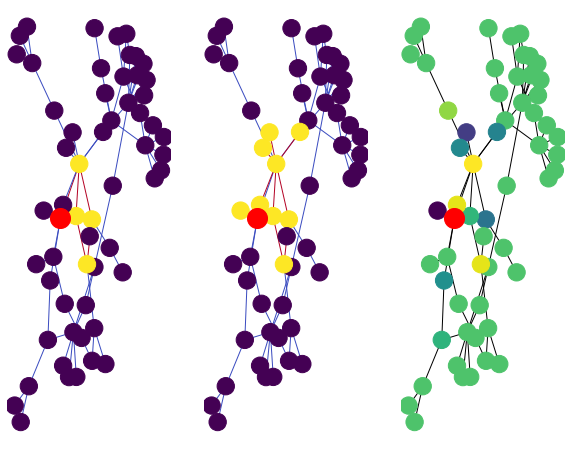

In [14]:
from torch_geometric.data import Data
from graphxai.explainers import PGExplainer, IntegratedGradExplainer

# Embedding layer name is final GNN embedding layer in the model
pgex = PGExplainer(model, emb_layer_name = 'gin2', max_epochs = 10, lr = 0.1)

# Required to first train PGExplainer on the dataset:
# Feed in entire data, the internal model uses the data's train mask
pgex.train_explanation_model(data)

# No training with Integrated Gradients, just run the model:
igex = IntegratedGradExplainer(model, criterion=criterion)

# Sample a random node for visualization. Also returns a ground truth explanation:
node_idx, gt_exp = dataset.choose_node(split = 'test')

# Get explanations from both IG and PGEx:
pgex_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)
ig_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

fig, ax = plt.subplots(1,3, figsize = (10, 8))

# Ground-truth explanations always provided as a list. In ShapeGGen, we use the first
#   element since it produces unique explanations. 
gt_exp[0].visualize_node(num_hops = 3, graph_data = data, ax = ax[0])
pgex_exp.visualize_node(num_hops = 3, graph_data = data, ax = ax[1])
ig_exp.visualize_node(num_hops = 3, graph_data = data, ax = ax[2])


Now we move to evaluate the explanations. `GraphXAI` provides fairness, faithfulness, stability, and accuracy metrics. Here we only use accuracy as it's more directly interpretable with respect to our above plot.

In [15]:
from graphxai.metrics import graph_exp_acc

# Accuracy for each method:
pg_acc = graph_exp_acc(gt_exp = gt_exp[0], generated_exp = pgex_exp)

# Threshold is the lower bound for which we consider a node to be "positive". 
#   Here we take 80% of the maximum value for the node importance of integrated gradients.
ig_acc = graph_exp_acc(gt_exp = gt_exp[0], generated_exp = ig_exp, threshold = ig_exp.node_imp.max().item() * 0.8)

print('PGExplainer Accuracy: {:.4f}'.format(pg_acc))
print('Integrated Gradients Accuracy: {:.4f}'.format(ig_acc))

PGExplainer Accuracy: 0.5000
Integrated Gradients Accuracy: 0.3333


We see that both of the explainers are able to capture some of the ground-truth explanation, but not all of it. PGExplainer gets about half of the correct nodes in the ground-truth explanation.